In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm as tqdm
from skimage import io, transform, img_as_ubyte
from skimage.feature import hog, local_binary_pattern, greycomatrix
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from cv2 import calcHist
from copy import deepcopy
from scipy.cluster.vq import *
import matplotlib.pyplot as plt

In [2]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [3]:
DATA_FOLDER = os.path.join(os.getcwd(), 'data')
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'train')
DATA_SIZE = 224

## Train Data

In [4]:
train = []
test = []
for category in CATEGORIES:
    filelist = [file for file in os.listdir(os.path.join(TRAIN_FOLDER, category)) if file.endswith('.png')]
    divide = round(len(filelist)/2)
    print('{} -> {}'.format(category, divide))
    for file in range(divide):
        train.append([os.path.join(TRAIN_FOLDER, category, filelist[file]), category, []])
    for file in range(divide, len(filelist)):
        test.append([os.path.join(TRAIN_FOLDER, category, filelist[file]), category, []])
train = pd.DataFrame(train, columns=['path', 'species', 'data'])
test = pd.DataFrame(test, columns=['path', 'species', 'data'])
print(train.shape)
print(test.shape)
train.head(2)

Black-grass -> 132
Charlock -> 195
Cleavers -> 144
Common Chickweed -> 306
Common wheat -> 110
Fat Hen -> 238
Loose Silky-bent -> 327
Maize -> 110
Scentless Mayweed -> 258
Shepherds Purse -> 116
Small-flowered Cranesbill -> 248
Sugar beet -> 192
(2376, 3)
(2374, 3)


,path,species,data
0,C:\Users\s110024\Documents\CV\HW1\data\train\B...,Black-grass,[]
1,C:\Users\s110024\Documents\CV\HW1\data\train\B...,Black-grass,[]


In [5]:
for i, file in tqdm(enumerate(train['path'])):  # 2376 in train
    img = io.imread(file)
    img = transform.resize(img, [DATA_SIZE, DATA_SIZE, 3])
    img = img_as_ubyte(img)
    train['data'][i] = img

0it [00:00, ?it/s]C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
2376it [01:57, 20.22it/s]


(224, 224, 3)


C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


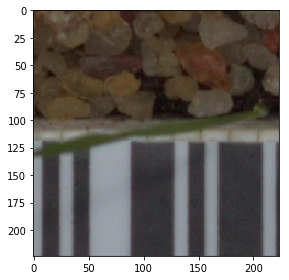

C:\Users\s110024\Documents\CV\HW1\data\train\Black-grass\0050f38b3.png
Black-grass


In [6]:
print(train['data'][0].shape)
io.imshow(train['data'][0])
io.show()
print(train['path'][0])
print(train['species'][0])

## Test Data

In [7]:
for i, file in tqdm(enumerate(test['path'])): # 2374 in train
    img = io.imread(file)
    img = transform.resize(img, [DATA_SIZE, DATA_SIZE, 3])
    img = img_as_ubyte(img)
    test['data'][i] = img

0it [00:00, ?it/s]C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
2374it [01:55, 20.52it/s]


(224, 224, 3)


C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


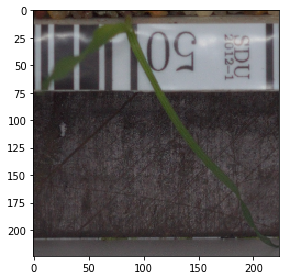

In [8]:
print(test['data'][0].shape)
io.imshow(test['data'][0])
io.show()

## Raw image

In [9]:
correct = 0
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['data'][testID] - train['data'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    if test['species'][testID] == train['species'][answerID]:
        correct = correct+1

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [38:46<00:00,  1.02it/s]


In [10]:
print('Accuracy: %f' %(correct/len(test)))

Accuracy: 0.457035


## Using HOG

In [11]:
train['grayscale'] = ""
train['hog_image'] = ""
for i in tqdm(range(len(train))):
    train['grayscale'][i] = img_as_ubyte(rgb2gray(train['data'][i]))
    normalised_blocks, train['hog_image'][i] = hog(train['grayscale'][i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(8, 8), visualise=True)

  0%|                                                                                         | 0/2376 [00:00<?, ?it/s]C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████████████████████████████████████████████████████████████████████████| 2376/2376 [07:33<00:00,  5.24it/s]


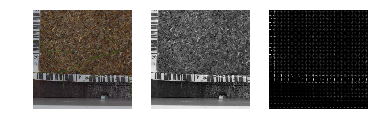

In [12]:
plt.subplot(1,3,1)
plt.imshow(train['data'][10])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train['grayscale'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train['hog_image'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [13]:
test['grayscale'] = ""
test['hog_image'] = ""
for i in tqdm(range(len(test))):
    test['grayscale'][i] = img_as_ubyte(rgb2gray(test['data'][i]))
    normalised_blocks, test['hog_image'][i] = hog(test['grayscale'][i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(8, 8), visualise=True)

  0%|                                                                                         | 0/2374 [00:00<?, ?it/s]C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [08:01<00:00,  4.93it/s]


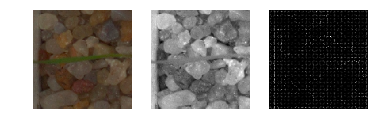

In [14]:
plt.subplot(1,3,1)
plt.imshow(test['data'][10])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(test['grayscale'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test['hog_image'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [15]:
correct=0
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['hog_image'][testID] - train['hog_image'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    if test['species'][testID] == train['species'][answerID]:
        correct = correct+1

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [22:08<00:00,  1.79it/s]


In [16]:
print('Accuracy: %f' %(correct/len(test)))

Accuracy: 0.204718


## Using Local Binary Pattern

In [17]:
train['lbp_image'] = ""
for i in tqdm(range(len(train))):
    train['lbp_image'][i] = local_binary_pattern(train['grayscale'][i], P=24, R=8)

100%|██████████████████████████████████████████████████████████████████████████████| 2376/2376 [01:29<00:00, 26.52it/s]


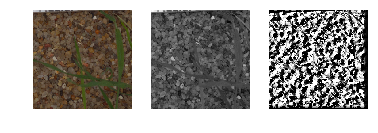

In [18]:
plt.subplot(1,3,1)
plt.imshow(train['data'][20])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train['grayscale'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train['lbp_image'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [19]:
test['lbp_image'] = ""
for i in tqdm(range(len(test))):
    test['lbp_image'][i] = local_binary_pattern(test['grayscale'][i], P=24, R=8)

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [01:26<00:00, 27.41it/s]


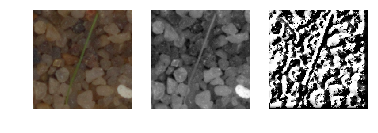

In [20]:
plt.subplot(1,3,1)
plt.imshow(test['data'][20])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(test['grayscale'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test['lbp_image'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [21]:
print(test['lbp_image'][20])

[[1.6515073e+07 1.6515073e+07 1.6646145e+07 ... 3.6044800e+05
  5.1609600e+05 5.2019200e+05]
 [1.6515073e+07 1.4417921e+07 1.3500417e+07 ... 0.0000000e+00
  2.6214400e+05 1.9251200e+05]
 [1.6515075e+07 1.4417923e+07 1.4548995e+07 ... 0.0000000e+00
  2.7852800e+05 4.2188800e+05]
 ...
 [0.0000000e+00 0.0000000e+00 3.0000000e+00 ... 1.4336000e+04
  1.6320000e+04 8.1280000e+03]
 [0.0000000e+00 0.0000000e+00 1.3100000e+02 ... 8.1600000e+03
  8.1280000e+03 8.1280000e+03]
 [9.6000000e+01 6.4000000e+01 1.9800000e+02 ... 8.1600000e+03
  8.1280000e+03 8.1280000e+03]]


In [22]:
correct=0
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['lbp_image'][testID] - train['lbp_image'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    if test['species'][testID] == train['species'][answerID]:
        correct = correct+1

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [24:43<00:00,  1.60it/s]


In [23]:
print('Accuracy: %f' %(correct/len(test)))

Accuracy: 0.192081


In [24]:
print(train['grayscale'][0])

[[ 48  45  53 ...  82  84  71]
 [ 48  50  59 ...  85  83  72]
 [ 47  53  61 ...  82  79  73]
 ...
 [137 150 149 ...  83  61  50]
 [139 149 148 ...  82  65  55]
 [130 140 139 ...  78  61  48]]


## Using Co-occurrence Matrix

In [25]:
train['comatrix'] = ""
for i in tqdm(range(len(train))):
    train['comatrix'][i] = greycomatrix(train['grayscale'][i], distances=[1], angles=[0])

  0%|                                                                                         | 0/2376 [00:00<?, ?it/s]C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):
100%|████████████████████████████████████████████████████████████████████████████| 2376/2376 [00:01<00:00, 1200.33it/s]


C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


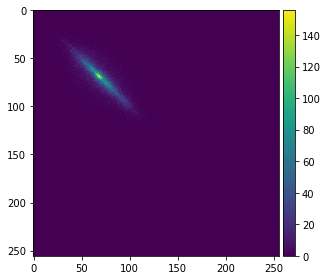

In [26]:
io.imshow(train['comatrix'][20][:,:,0,0])

In [27]:
test['comatrix'] = ""
for i in tqdm(range(len(test))):
    test['comatrix'][i] = greycomatrix(test['grayscale'][i], distances=[1], angles=[0])

  0%|                                                                                         | 0/2374 [00:00<?, ?it/s]C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):
100%|████████████████████████████████████████████████████████████████████████████| 2374/2374 [00:01<00:00, 1301.83it/s]


C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


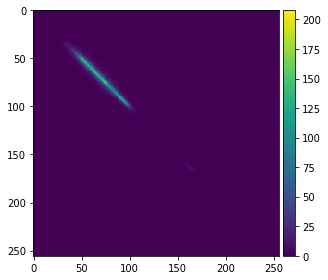

In [28]:
io.imshow(test['comatrix'][20][:,:,0,0])

In [29]:
correct=0
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['comatrix'][testID] - train['comatrix'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    if test['species'][testID] == train['species'][answerID]:
        correct = correct+1

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [34:03<00:00,  1.16it/s]


In [30]:
print('Accuracy: %f' %(correct/len(test)))

Accuracy: 0.396799


## Using Color histogram

In [31]:
BINS = 256

In [32]:
train['hist'] = ""
hist = np.zeros([3, BINS, 1])
for i in tqdm(range(len(train))):
    for j in range(0,3):
        hist[j] = calcHist([train['data'][i][:,:,j]], [0], None, [BINS], [0, 256])
    train['hist'][i] = deepcopy(hist)

100%|████████████████████████████████████████████████████████████████████████████| 2376/2376 [00:02<00:00, 1063.91it/s]


50176.0


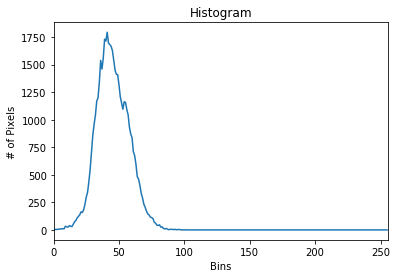

In [33]:
plt.figure()
plt.title("Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(train['hist'][100][2])
plt.xlim([0, BINS])
print(train['hist'][100][2].sum())

In [34]:
test['hist'] = ""
hist = np.zeros([3, BINS, 1])
for i in tqdm(range(len(test))):
    for j in range(0,3):
        hist[j] = calcHist([test['data'][i][:,:,j]], [0], None, [BINS], [0, 256])
    test['hist'][i] = deepcopy(hist)

100%|████████████████████████████████████████████████████████████████████████████| 2374/2374 [00:01<00:00, 1376.50it/s]


50176.0


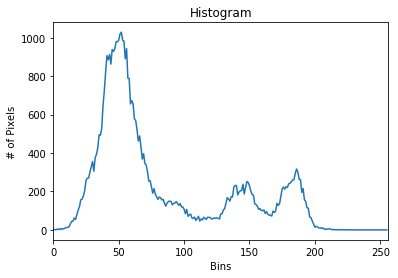

In [35]:
plt.figure()
plt.title("Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(test['hist'][100][2])
plt.xlim([0, BINS])
print(train['hist'][100][2].sum())

In [36]:
correct = 0
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['hist'][testID] - train['hist'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    if test['species'][testID] == train['species'][answerID]:
        correct = correct+1

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [05:20<00:00,  7.40it/s]


In [37]:
print('Accuracy: %f' %(correct/len(test)))

Accuracy: 0.573715


## Using Gabor Filters

In [38]:
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

In [39]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [40]:
train['gabor'] = ""
gabor = np.zeros([len(kernels), 2])
for i in tqdm(range(len(train))):
    gabor = compute_feats(train['grayscale'][i], kernels)
    train['gabor'][i] = deepcopy(gabor)

100%|██████████████████████████████████████████████████████████████████████████████| 2376/2376 [05:14<00:00,  7.56it/s]


In [41]:
test['gabor'] = ""
gabor = np.zeros([len(kernels), 2])
for i in tqdm(range(len(test))):
    gabor = compute_feats(test['grayscale'][i], kernels)
    test['gabor'][i] = deepcopy(gabor)

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [04:55<00:00,  8.02it/s]


In [42]:
correct=0
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['gabor'][testID] - train['gabor'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    if test['species'][testID] == train['species'][answerID]:
        correct = correct+1

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [04:21<00:00,  9.07it/s]


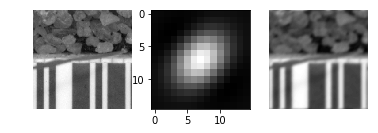

In [43]:
plt.subplot(1,3,1)
plt.imshow(train['grayscale'][0], cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(kernels[6], cmap=plt.cm.gray)
#plt.axis('off')

filtered = ndi.convolve(train['grayscale'][0], kernels[6], mode='wrap')
plt.subplot(1,3,3)
plt.imshow(filtered, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [44]:
print('Accuracy: %f' %(correct/len(test)))

Accuracy: 0.174389


## Using Bag-of-Features

In [45]:
# pip install --user opencv-contrib-python==3.3.0.10

sift = cv2.xfeatures2d.SIFT_create()

In [46]:
des_list = []
for i in tqdm(range(len(train))):
    (kps, descs) = sift.detectAndCompute(train['data'][i], None)
    des_list.append(descs)

100%|██████████████████████████████████████████████████████████████████████████████| 2376/2376 [00:49<00:00, 48.17it/s]


In [47]:
descriptors = des_list[0]
for descriptor in tqdm(des_list[1:]):
    descriptors = np.vstack((descriptors, descriptor))  

100%|██████████████████████████████████████████████████████████████████████████████| 2375/2375 [03:51<00:00, 10.27it/s]


In [48]:
descriptors.shape

(467224, 128)

In [49]:
# Perform k-means clustering
k=512
voc, variance = kmeans(descriptors, k, 1) 

In [50]:
train['features'] = ""
for i in tqdm(range(len(train))):
    im_features = np.zeros(k, "float32")
    words, distance = vq(des_list[i], voc)
    for w in words:
        im_features[w] += 1
    train['features'][i] = deepcopy(im_features)

100%|█████████████████████████████████████████████████████████████████████████████| 2376/2376 [00:04<00:00, 494.87it/s]


In [51]:
des_list = []
for i in tqdm(range(len(test))):
    (kps, descs) = sift.detectAndCompute(test['data'][i], None)
    des_list.append(descs)

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [00:49<00:00, 47.78it/s]


In [52]:
test['features'] = ""
for i in tqdm(range(len(test))):
    im_features = np.zeros(k, "float32")
    words, distance = vq(des_list[i], voc)
    for w in words:
        im_features[w] += 1
    test['features'][i] = deepcopy(im_features)

100%|█████████████████████████████████████████████████████████████████████████████| 2374/2374 [00:04<00:00, 545.79it/s]


In [53]:
correct = 0
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['features'][testID] - train['features'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    if test['species'][testID] == train['species'][answerID]:
        correct = correct+1

100%|██████████████████████████████████████████████████████████████████████████████| 2374/2374 [05:16<00:00,  7.51it/s]


In [54]:
print('Accuracy: %f' %(correct/len(test)))

Accuracy: 0.155434
